<a name='select_gpu'></a>
# 0. GPU management


## Funciones

In [1]:
# comprueba el GPU-id en uso actual
def GPU_getAssignment():
    try:
        devices = cuda.gpus
        dev=devices.current
        return dev.id
    except:
        return -1

In [2]:
# libera el GPU-id pasado por parámetro
def GPU_release(gpu_device_id):
    if gpu_device_id != -1:
        cuda.select_device(gpu_device_id)
        cuda.close()
        print("GPU liberada id={}".format(gpu_device_id))
    else:
        print("Sin GPU asignada. Nada que liberar.")

# 1. LIBRERÍAS

Librerías más destacadas y su función en este notebook:

* `glob`: para trabajar con ficheros

* `os` y `os.path`: para operaciones con ficheros

* `pytorch`: para trabajar con tensores, estructuras de ML...


* `numpy`: para trabajar con estructuras matemáticas

* `matplotlib`:
> * `pyplot`: para mostrar gráficas e imágenes 
> * `image`: para mostrar imágenes
> * `colors`: para mapear colores de segmentación

* `sklearn`: para calcular medidas estadísticas

* `time`: para medir los tiempos de training


In [3]:
###############################
##### importing libraries #####
###############################
#Global Libraries
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random
import os, shutil
import glob
from tqdm import tqdm


#Torch 
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

#Open CV
import cv2

In [4]:
#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

## 1.2. Asignar GPU

In [5]:
!nvidia-smi

Sun Feb 26 12:31:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   41C    P0    38W / 250W |   8937MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100S-PCI...  Off  | 00000000:5E:00.0 Off |                    0 |
| N/A   

In [6]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

cuda


# 2. Directories (COLAB vs. LOCAL) and Global Parameters


In [7]:
if 'google.colab' in str(get_ipython()):
    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    drive.mount('/content/drive')
    os.chdir('/content/personal_drive/My Drive/UNED/TFM')
    base_dir = '/content/drive/MyDrive/Colab Notebooks/UNED-TFM'
    DATASET_PATH = os.path.join(base_dir, "Final Clinical Image")
    base_dir_clas = '/content/drive/MyDrive/Colab Notebooks/UNED-TFM/Federated Model'
    print('Running on CoLab')
else:
    os.chdir('../')
    base_dir = '.'
    base_dir_clas = '.'
    DATASET_PATH = os.path.join(base_dir, "Final Clinical Image")
    print('Not running on CoLab')

Not running on CoLab


In [8]:
!ls

'02. Base de Datos Organizado.zip'  'Output FedAVG'	      Scripts_zip.zip
 create_folder.ipynb		    'Output FedAVG_zip.zip'   test_zip.zip
 create_zip.ipynb		    'Output FedEN'	      TFM
 Delete_Folder.ipynb		    'Output Global'	      unzip.ipynb
'Final Clinical Image'		     Output.zip
'Final Clinical Image_aug'	     Scripts


In [9]:
DATASET_PATH

'./Final Clinical Image'

### **Global Parameters**

In [147]:
#######################################################
###### Hyperparameters for federated learning #########
#######################################################
#Model selection "last" or "best"
model_selection="last"
run = 3


#General Parameters
num_rounds = 500
epochs = 10
batch_size = 64
image_size = 128
learning_rate=0.0005

# Ensemble Method Parameters
K_models=5
Q_client_groups=2
ages=num_rounds/K_models


In [148]:
# In case of Run where random split select number clients and percentage split
if run==2:
    split_perc = [0.5, 0.5]
elif run==3:
    split_perc = [0.33, 0.33, 0.34]
elif run==4:
    split_perc = [0.7, 0.15, 0.15]
elif run==5:
    split_perc = [0.4, 0.4, 0.2]
elif run==6:
    split_perc = [0.25, 0.25, 0.25, 0.25]
elif run==7:
    split_perc = [0.55, 0.15, 0.15, 0.15]
elif run==8:
    split_perc = [0.35, 0.35, 0.15, 0.15]
elif run==9:
    split_perc = [0.2, 0.2, 0.2, 0.2,0.2]
elif run==10:
    split_perc = [0.4, 0.15, 0.15, 0.15, 0.15]

#Number of clients
split="manual"
if run == 1:
    clients_list = ["A", "B"]
    num_clients = len(clients_list)
    split_perc = [0.87, 0.13]
else:
    clients_list = ["all"]
    num_clients = len(split_perc)
    split="random"

In [149]:
#List of parameters
Glob_Param = {"run": [run], "num_clients": [num_clients], "split": [split],
              "split_perc": [split_perc], "num_rounds": [num_rounds], "epochs": [epochs], 
              "batch_size": [batch_size], "image_size": [image_size], "learning_rate": [learning_rate],
              "ages": [ages], "K_models": [K_models], "Q_client_groups": [Q_client_groups]}

### **Get Image Directories**

In [150]:
def get_client_directories(list_clients, base_image_path):
  # Create list of directories to fill afterwards
  train_dir = {x: [] for x in list_clients} 
  validation_dir = {x: [] for x in list_clients} 
  test_dir = {x: [] for x in list_clients} 

  #Fill the list
  for client in list_clients:
    client_path = os.path.join(base_image_path, "ds_"+client)
    client_path_image = os.path.join(client_path, "images")
    train_dir[client].append(os.path.join(client_path_image, "train"))
    validation_dir[client].append(os.path.join(client_path_image, "valid"))
    test_dir[client].append(os.path.join(client_path_image, "test"))
  return train_dir, validation_dir, test_dir

In [151]:
train_dir, validation_dir, test_dir = get_client_directories(clients_list, DATASET_PATH)

Totals from ALL folder to get total figures

In [152]:
# In order to check total numbers we define ALL directories 
###############
# Dataset All #
###############
DATASET_PATH_ALL = os.path.join(DATASET_PATH, "ds_all")
DATASET_PATH_ALL_IMAGE = os.path.join(DATASET_PATH_ALL, "images")
# Directories for our training,
# validation and test splits
ALL_train_dir = os.path.join(DATASET_PATH_ALL_IMAGE, 'train')
ALL_validation_dir = os.path.join(DATASET_PATH_ALL_IMAGE, 'valid')
ALL_test_dir = os.path.join(DATASET_PATH_ALL_IMAGE, 'test')

#Check total numbers#
# Directory with our training benign pictures
ALL_train_ben_dir = os.path.join(ALL_train_dir, 'benign')
#print(train_ben_dir)
# Directory with our training malignant pictures
ALL_train_mal_dir = os.path.join(ALL_train_dir, 'malignant')
#print(train_mal_dir)
# Directory with our training normal pictures
ALL_train_nor_dir = os.path.join(ALL_train_dir, 'normal')
#print(train_nor_dir)

# Directory with our validation benign pictures
ALL_val_ben_dir = os.path.join(ALL_validation_dir, 'benign')
# Directory with our validation malignant pictures
ALL_val_mal_dir = os.path.join(ALL_validation_dir, 'malignant')
# Directory with our validation normal pictures
ALL_val_nor_dir = os.path.join(ALL_validation_dir, 'normal')

# Directory with our test benign pictures
ALL_test_ben_dir = os.path.join(ALL_test_dir, 'benign')
# Directory with our test malignant pictures
ALL_test_mal_dir = os.path.join(ALL_test_dir, 'malignant')
# Directory with our test normal pictures
ALL_test_nor_dir = os.path.join(ALL_test_dir, 'normal')

# 3. Get number of classes and Total Figures

In [153]:

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
# eg. class -> 26.Pont_du_Gard
for data_path in glob.glob(ALL_train_dir + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

#2.
# split train valid from train paths (80,20)
#train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 
valid_image_paths = []
for data_path in glob.glob(ALL_validation_dir + '/*'):
    valid_image_paths.append(glob.glob(data_path + '/*'))

valid_image_paths = list(flatten(valid_image_paths))


#3.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(ALL_test_dir + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

train_image_path example:  ./Final Clinical Image/ds_all/images/train/benign/benign (123).png
class example:  malignant
Train size: 755
Valid size: 93
Test size: 95


In [154]:
print('total training benign images:', len(os.listdir(ALL_train_ben_dir)))
print('total training malignant images:', len(os.listdir(ALL_train_mal_dir)))
print('total training normal images:', len(os.listdir(ALL_train_nor_dir)))
print("-----------------------------")
print('total validation benign images:', len(os.listdir(ALL_val_ben_dir)))
print('total validation malignant images:', len(os.listdir(ALL_val_mal_dir)))
print('total validation normal images:', len(os.listdir(ALL_val_nor_dir)))
print("-----------------------------")
print('total test benign images:', len(os.listdir(ALL_test_ben_dir)))
print('total test malignant images:', len(os.listdir(ALL_test_mal_dir)))
print('total test normal images:', len(os.listdir(ALL_test_nor_dir)))

total training benign images: 437
total training malignant images: 211
total training normal images: 107
-----------------------------
total validation benign images: 54
total validation malignant images: 26
total validation normal images: 13
-----------------------------
total test benign images: 55
total test malignant images: 27
total test normal images: 13


#######
       **Create dictionary for class indexes**
#######

In [155]:
num_classes=len(classes)
classes.sort()
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}
print(idx_to_class )

{0: 'benign', 1: 'malignant', 2: 'normal'}


**B has one class less, so specific variable class if split is manual to get classes of B**

In [156]:
if split=="manual":
  classes_B = [] #to store class values

  #1.
  # get all the paths from train_data_path and append image paths and class to to respective lists
  # eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
  # eg. class -> 26.Pont_du_Gard
  for data_path in glob.glob(train_dir["B"][0] + '/*'):
      classes_B.append(data_path.split('/')[-1]) 
      train_image_paths.append(glob.glob(data_path + '/*'))

# 4. Create Dataset Pytorch

### **Transfomrs**

In [157]:
#######################################################
#               Define Transforms
#######################################################

#To define an augmentation pipeline, you need to create an instance of the Compose class.
#As an argument to the Compose class, you need to pass a list of augmentations you want to apply. 
#A call to Compose will return a transform function that will perform image augmentation.
#(https://albumentations.ai/docs/getting_started/image_augmentation/)

train_transforms = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        #transforms.RandomRotation(20),
        transforms.RandomResizedCrop(image_size),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])

test_transforms = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        #transforms.RandomRotation(20),
        transforms.Resize((image_size,image_size)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])

### **Create Dataset from Folders**

Function to merge datasets from different clients into one dataset

In [158]:
def merge_dataset(client_datasets):
    i=0
    for ds in client_datasets:
        if i==0:
            merge_ds=ds
        else:
            merge_ds+=ds
        i+=1
    return merge_ds

In [159]:
if split=="manual":
    train_dataset_client=[]
    test_dataset_client=[]
    val_dataset_client=[]
    i=0
    for client in clients_list:
        print(train_dir[client])
        train_dataset_client.append(datasets.ImageFolder(train_dir[client][0], transform=train_transforms))
        test_dataset_client.append(datasets.ImageFolder(test_dir[client][0], transform=test_transforms))
        val_dataset_client.append(datasets.ImageFolder(validation_dir[client][0], transform=test_transforms))
        #validation_dataset+=datasets.ImageFolder(validation_dir[client][0], transform=test_transforms)
        #test_dataset+=datasets.ImageFolder(test_dir[client][0], transform=test_transforms)
    test_dataset=merge_dataset(test_dataset_client)
    validation_dataset=merge_dataset(val_dataset_client)
#We take the entire dataset "ALL", so we only have one client in the list and we need to apply .random_split
else:
    for client in clients_list:
        train_dataset_glob = datasets.ImageFolder(train_dir[client][0], transform=train_transforms)
        train_dataset_client = torch.utils.data.random_split(train_dataset_glob, split_perc, generator=torch.Generator().manual_seed(42))
        test_dataset_glob = datasets.ImageFolder(test_dir[client][0], transform=test_transforms)
        test_dataset_client = torch.utils.data.random_split(test_dataset_glob, split_perc, generator=torch.Generator().manual_seed(42))
        validation_dataset_glob = datasets.ImageFolder(validation_dir[client][0], transform=test_transforms)
        val_dataset_client = torch.utils.data.random_split(validation_dataset_glob, split_perc, generator=torch.Generator().manual_seed(42))
        #If random split then the glob dataset contains the full population
        validation_dataset=validation_dataset_glob
        test_dataset=test_dataset_glob


### **Load Dataset Pytorch**

In [160]:
# Creating a pytorch loader for a Deep Learning model
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in train_dataset_client]

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
val_loader_client = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in val_dataset_client]


# 5. Define Neural Network

In [161]:
################################
##### Neural Network model #####
################################

cfg = {
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Flatten(),
            #nn.Linear(8192, 512),
            nn.Linear(int(512*image_size/32*image_size/32), 512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 3)
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        output = F.log_softmax(out, dim=1)
        return output

    def _make_layers(self, cfg):
        layers = []
        in_channels = 1
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

# 6. Predict Test Dataset to check Generalization Accuracy

### Functions to Predict

**Predict a Dataset**

In [162]:
def prediction_dataset(global_model, test_loader, method):
  if method == "ENSEMBLE":
    for model in global_model:
        model.eval()
  else:
    global_model.eval()

  pred_final=[]
  target_final=[]
  correct = 0
  confusion_matrix_torch = torch.zeros(num_classes, num_classes)
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
                data, target = data.to(DEVICE), target.to(DEVICE)
                data = data.float()
                if method == "ENSEMBLE": 
                  global_output=[]
                  for model in global_model:
                    output_model = model(data)
                    global_output.append(output_model)
                  final_output=torch.mean(torch.stack([output.float() for output in global_output], 0),dim=0, keepdim=True)
                  pred = final_output[0].argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                  correct += pred.eq(target.view_as(pred)).sum().item()
                if method == "AVG":
                  output = global_model(data)
                  pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                  correct += pred.eq(target.view_as(pred)).sum().item()

                for t, p in zip(target.view(-1), pred.view(-1)):
                  confusion_matrix_torch[t.long(), p.long()] += 1
                pred_final.extend(pred.to('cpu').numpy().tolist())
                target_final.extend(target.to('cpu').numpy().tolist())

  acc = correct/len(test_loader.dataset)

  return target_final, pred_final, confusion_matrix_torch, acc

**Predict a simple Image**

In [163]:
def predict_image(global_model, image, method):
    if method == "ENSEMBLE":
      global_output=[]
      for model in global_model:
        model.eval()
        output_model = model(image)
        global_output.append(output_model)
      final_output=torch.mean(torch.stack([output.float() for output in global_output], 0),dim=0, keepdim=True)
      pred = final_output[0].argmax(dim=1, keepdim=True)
    
    if method == "AVG":
      global_model.eval()
      output_model = global_model(image)
      pred = output_model.argmax(dim=1, keepdim=True)
    
    return pred

# 7. Compare methods(AVG-Ensemble) in the Validation Data

### Read JSON file

In [164]:
# Opening JSON file
import json
BASE_OUTPUT_AVG = os.path.join(base_dir_clas, "Output FedAVG")
BASE_OUTPUT_ENS = os.path.join(base_dir_clas, "Output FedEN")
BASE_OUTPUT_GLOB = os.path.join(base_dir_clas, "Output Global")
#Specific Run
BASE_OUTPUT_AVG_RUN=os.path.join(BASE_OUTPUT_AVG, "Run "+str(run))
BASE_OUTPUT_ENS_RUN=os.path.join(BASE_OUTPUT_ENS, "Run "+str(run))
BASE_OUTPUT_GLOB_RUN=os.path.join(BASE_OUTPUT_GLOB, "Run "+str(run))
#Get Models
MODEL_PATH_AVG = os.path.join(BASE_OUTPUT_AVG_RUN, "Models")
MODEL_PATH_ENS = os.path.join(BASE_OUTPUT_ENS_RUN, "Models")
if model_selection=="last":
    MODEL_PATH_final_AVG = os.path.join(MODEL_PATH_AVG, "vgg16_global.pth")
    MODEL_PATH_final_ENS = os.path.join(MODEL_PATH_ENS, "vgg16_global.pth")
if model_selection=="best":
    MODEL_PATH_final_AVG = os.path.join(MODEL_PATH_AVG, "vgg16_best.pth")
    MODEL_PATH_final_ENS = os.path.join(MODEL_PATH_ENS, "vgg16_best.pth")
#General Plot 
PLOT_PATHT_GLOB = os.path.join(BASE_OUTPUT_GLOB_RUN, "Plots")
PLOT_PATHT_GLOB_ACC = os.path.join(PLOT_PATHT_GLOB, "plot_acc.png")
PLOT_PATHT_GLOB_LOSS = os.path.join(PLOT_PATHT_GLOB, "plot_loss.png")
PLOT_PATHT_GLOB_CLI = os.path.join(PLOT_PATHT_GLOB, "plot_clients.png")

#Get Historical 
PLOT_PATH_AVG = os.path.join(BASE_OUTPUT_AVG_RUN, "Plots")
PLOT_PATH_ENS = os.path.join(BASE_OUTPUT_ENS_RUN, "Plots")

PLOT_PATH_HIS_AVG = os.path.sep.join([PLOT_PATH_AVG, "plot_hist.json"])
PLOT_PATH_HIS_ENS = os.path.sep.join([PLOT_PATH_ENS, "plot_hist.json"])
with open(PLOT_PATH_HIS_ENS) as json_file:
    H_ENS = json.load(json_file)
with open(PLOT_PATH_HIS_AVG) as json_file:
    H_AVG = json.load(json_file)

### Compare Accuracy

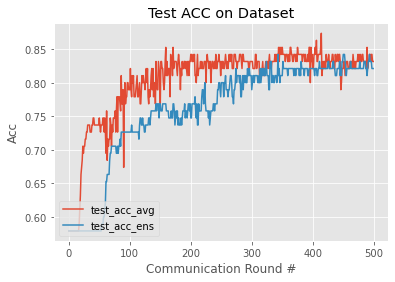

In [165]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H_AVG["test_acc"], label="test_acc_avg")
plt.plot(H_ENS["test_acc"], label="test_acc_ens")
plt.title("Test ACC on Dataset")
plt.xlabel("Communication Round #")
plt.ylabel("Acc")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATHT_GLOB_ACC)

### Compare Loss

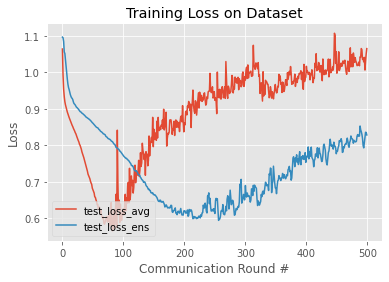

In [166]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H_AVG["test_loss"], label="test_loss_avg")
plt.plot(H_ENS["test_loss"], label="test_loss_ens")
plt.title("Training Loss on Dataset")
plt.xlabel("Communication Round #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATHT_GLOB_LOSS)

### Load both Models

In [167]:
# determine the device to be used for training and evaluation
DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"
print(DEVICE)
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda:1" else False

cuda:1


In [168]:
loaded_model_ens = torch.load(MODEL_PATH_final_ENS, map_location=DEVICE)
loaded_model_avg = torch.load(MODEL_PATH_final_AVG, map_location=DEVICE)

**Function to get metrics**

In [169]:
def get_metric_val_clients(load_model,method):
    Val_Metric = {"Confusion_matrix": [], "Val_ACC": []}
    if split=="random":
      for i in range(num_clients):
        print("Validation Accuracy Client: ", i)
        target_final, pred_final, confusion_matrix_pred, acc = prediction_dataset(load_model, val_loader_client[i], method)
        Val_Metric["Confusion_matrix"].append(confusion_matrix_pred)
        Val_Metric["Val_ACC"].append(acc)
        print(confusion_matrix_pred)
        pred_final_arr=np.array(pred_final)
        unique_pred=np.unique(pred_final_arr)
        pred_labels=[]
        for label in list(unique_pred):
          pred_labels.append(idx_to_class[label])
        print(pred_labels)
        print(classification_report(target_final, pred_final, target_names=pred_labels))
        print(acc)
    else: 
      i=0
      for client in clients_list:
        print("Validation Accuracy Client: ", client)
        target_final, pred_final, confusion_matrix_pred, acc = prediction_dataset(load_model, val_loader_client[i], method)
        Val_Metric["Confusion_matrix"].append(confusion_matrix_pred)
        Val_Metric["Val_ACC"].append(acc)
        print(confusion_matrix_pred)
        pred_final_arr=np.array(pred_final)
        unique_pred=np.unique(pred_final_arr)
        pred_labels=[]
        for label in list(unique_pred):
          pred_labels.append(idx_to_class[label])
        print(pred_labels)
        if client == "B" and len(pred_labels)==2 and "normal" in pred_labels:
            print(classification_report(target_final, pred_final, target_names=classes))
        else:
            print(classification_report(target_final, pred_final, target_names=pred_labels))
        print(acc)
        i+=1
    return Val_Metric

#### Get Metrics AVG

**Global**

In [170]:
target_final_avg_glob, pred_final_avg_glob, confusion_matrix_torch_avg_glob, acc_avg_glob = prediction_dataset(loaded_model_avg, val_loader, "AVG")
print(confusion_matrix_torch_avg_glob)
print(acc_avg_glob)
pred_final_arr=np.array(pred_final_avg_glob)
unique_pred=np.unique(pred_final_arr)
pred_labels=[]
for label in list(unique_pred):
    pred_labels.append(idx_to_class[label])
print(classification_report(target_final_avg_glob, pred_final_avg_glob, target_names=pred_labels))

tensor([[46.,  5.,  3.],
        [ 4., 19.,  3.],
        [ 2.,  0., 11.]])
0.8172043010752689
              precision    recall  f1-score   support

      benign       0.88      0.85      0.87        54
   malignant       0.79      0.73      0.76        26
      normal       0.65      0.85      0.73        13

    accuracy                           0.82        93
   macro avg       0.77      0.81      0.79        93
weighted avg       0.83      0.82      0.82        93



**Clients**

In [171]:
Val_AVG = get_metric_val_clients(loaded_model_avg, "AVG")

Validation Accuracy Client:  0
tensor([[16.,  1.,  1.],
        [ 1.,  5.,  0.],
        [ 1.,  0.,  6.]])
['benign', 'malignant', 'normal']
              precision    recall  f1-score   support

      benign       0.89      0.89      0.89        18
   malignant       0.83      0.83      0.83         6
      normal       0.86      0.86      0.86         7

    accuracy                           0.87        31
   macro avg       0.86      0.86      0.86        31
weighted avg       0.87      0.87      0.87        31

0.8709677419354839
Validation Accuracy Client:  1
tensor([[13.,  2.,  2.],
        [ 1.,  8.,  2.],
        [ 0.,  0.,  3.]])
['benign', 'malignant', 'normal']
              precision    recall  f1-score   support

      benign       0.93      0.76      0.84        17
   malignant       0.80      0.73      0.76        11
      normal       0.43      1.00      0.60         3

    accuracy                           0.77        31
   macro avg       0.72      0.83      0.73   

#### Get Metrics ENS

**Global**

In [172]:
target_final_ens_glob, pred_final_ens_glob, confusion_matrix_torch_ens_glob, acc_ens_glob = prediction_dataset(loaded_model_ens, val_loader, "ENSEMBLE")
print(confusion_matrix_torch_ens_glob)
print(acc_ens_glob)
pred_final_arr=np.array(pred_final_ens_glob)
unique_pred=np.unique(pred_final_arr)
pred_labels=[]
for label in list(unique_pred):
    pred_labels.append(idx_to_class[label])
print(classification_report(target_final_ens_glob, pred_final_ens_glob, target_names=pred_labels))

tensor([[47.,  4.,  3.],
        [ 5., 19.,  2.],
        [ 2.,  0., 11.]])
0.8279569892473119
              precision    recall  f1-score   support

      benign       0.87      0.87      0.87        54
   malignant       0.83      0.73      0.78        26
      normal       0.69      0.85      0.76        13

    accuracy                           0.83        93
   macro avg       0.79      0.82      0.80        93
weighted avg       0.83      0.83      0.83        93



**Clients**

In [173]:
Val_ENS = get_metric_val_clients(loaded_model_ens, "ENSEMBLE")

Validation Accuracy Client:  0
tensor([[16.,  1.,  1.],
        [ 1.,  5.,  0.],
        [ 1.,  0.,  6.]])
['benign', 'malignant', 'normal']
              precision    recall  f1-score   support

      benign       0.89      0.89      0.89        18
   malignant       0.83      0.83      0.83         6
      normal       0.86      0.86      0.86         7

    accuracy                           0.87        31
   macro avg       0.86      0.86      0.86        31
weighted avg       0.87      0.87      0.87        31

0.8709677419354839
Validation Accuracy Client:  1
tensor([[13.,  2.,  2.],
        [ 2.,  8.,  1.],
        [ 0.,  0.,  3.]])
['benign', 'malignant', 'normal']
              precision    recall  f1-score   support

      benign       0.87      0.76      0.81        17
   malignant       0.80      0.73      0.76        11
      normal       0.50      1.00      0.67         3

    accuracy                           0.77        31
   macro avg       0.72      0.83      0.75   

### Compare Clients

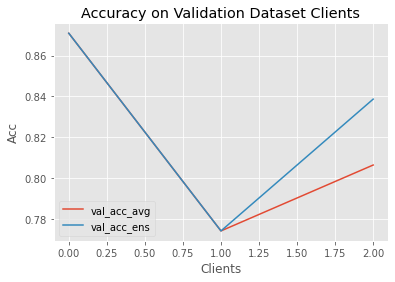

In [174]:
plt.style.use("ggplot")
plt.figure()
plt.plot(Val_AVG["Val_ACC"], label="val_acc_avg")
plt.plot(Val_ENS["Val_ACC"], label="val_acc_ens")
plt.title("Accuracy on Validation Dataset Clients")
plt.xlabel("Clients")
plt.ylabel("Acc")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATHT_GLOB_CLI)